**Sentiment analysis using ktrain library - Standard Method**

This notebook intends to build a classification model to predict sentiment analysis using ktrain library.

**Problem Description**

Sentiment analysis is a technique to predict the sentiment according with text classification. In this problem, we consider movies reviews from IMDB website. The reviews are classified as negative and positive.

**Dataset Description**

The dataset is loaded from https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz.

**-Overview**

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

**-Dataset**

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg).

**Ktrain Library**

Ktrain Library proposes many Neural Network models. Some problem applications which are covered in this library are image classification, text classification, classification model, etc. This library is an easy way to apply these models without many line codes. For more details [see](https://pypi.org/project/ktrain/).




# Importing libraries

In [ ]:
import os.path
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text # object to make text classification

# Data Preprocessing

## Loading the IMDB dataset review

The first step to build the model, is to load the dataset from https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [2]:
dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz",
                                  origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
                                  extract=True) # To download and extract the files
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb') # to indicate the directory

84131840/84125825 [==============================] - 9s 0us/step


In [3]:
print(os.path.dirname(dataset))
print(IMDB_DATADIR)

/root/.keras/datasets
/root/.keras/datasets/aclImdb


## Creating the training and test variables

When we create the training and test variables with the object text, we don’t need to take care about the text cleaning (tokenization, stemmer and others actions), this is made by this object with the aid of the preproc object (this is a transformer object). The argument maxlen is the number of words which will be considered to train and test the model. The parameter preprocess_mode choose which method we want to use, for example BERT or NBSVM. Classes indicates the classes in the problem. Here, we consider the BERT method.

In [4]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir=IMDB_DATADIR,
                                                                       classes=['pos','neg'],
                                                                       maxlen=500,
                                                                       train_test_names=['train','test'],
                                                                       preprocess_mode='bert')

detected encoding: utf-8
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


# Building the BERT model

The BERT model was developped by Google in 2018. This is a strong method for DNLP. To more details, I recomend the read of the [paper](https://arxiv.org/abs/1810.04805).

## Inititialzing the model

To initiate the model, we consider the attribute text_classifier, BERT is the method to classifier.

In [5]:
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc) # object to learn

Is Multi-Label? False
maxlen is 500
done.


## Training the model

To train the model there are some steps to follow. First we create the object learner, after we consider some attributes as lr_find to find the learn rate, lr_plot to verify the evolution of the learn rate by the loss, finally we fit the model with the attribute fit.

In [6]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6) # Visualizing the learn rate evolution by loss function

In [7]:
learner.lr_find() # Finding the best learning rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
4167/4167 [==============================] - 2503s 595ms/step - loss: 2.3709 - accuracy: 0.5741


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


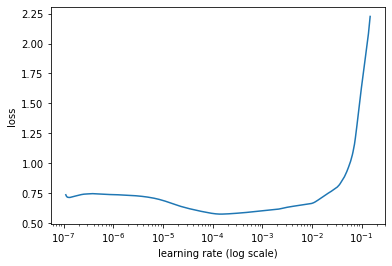

In [8]:
learner.lr_plot() # Visualizing the learn rate evolution by loss function

As seen, the learn rate associated to the minimal is around $1e-4$, but Google recomends to use a learn rate equal to $2e-5$.

In [9]:
learner.fit_onecycle(lr=2e-5,
                     epochs=1) # Fitting the model



begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 9470s 2s/step - loss: 0.2498 - accuracy: 0.8964 - val_loss: 0.1621 - val_accuracy: 0.9384


The final validation accuracy is $93.84\%$.

## Making predictions

To make predictions we must to create the object predictor with ktrain.get_predictor. The input parameters are learn.model and preproc, the last parameters is very important, it makes the text preprocessing.

In [10]:
predictor = ktrain.get_predictor(learner.model, preproc)  # creating the object

In [11]:
data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
         'The film really sucked. I want my money back.',
        'The plot had too many holes.',
        'What a beautiful romantic comedy. 10/10 would see again!',
         ] # List with some test reviews.

In [12]:
predictor.get_classes() # To verify the classes

['neg', 'pos']

In [13]:
predictor.predict(data) # Predicting

['neg', 'neg', 'neg', 'pos']

The predictions can be considered to be correct.

If you want to see the prabability, the parameter return_proba=True allow us to obtain it.

In [14]:
predictor.predict(data, return_proba=True) # Predicting with the probability

array([[0.99759763, 0.00240235],
       [0.9886126 , 0.01138739],
       [0.98323375, 0.01676632],
       [0.00284578, 0.99715424]], dtype=float32)

## Saving the model

The model can be saved to the disk. In case of necessity, the model can be reloaded. This is very practical to make applications.

In [15]:
predictor.save('/tmp/my_moviereview_predictor_BERT') # saving the model

In [16]:
predictor_save = ktrain.load_predictor('/tmp/my_moviereview_predictor_BERT') # creating the object to load the saved model

In [17]:
predictor_save.predict(['Groundhog Day is my favorite movie of all time!']) # Making a prediction with the loaded model.

['pos']

# Conclusion

We presented a simple example to demonstrate how to apply some functions of ktrain library to make text classification using BERT method. The results from the sentiment analysis are satisfactory, with a validation accuracy of $93.84\%$ using just $1$ epochs. The library offers facility to build the models with some lines and good score results. Keep in mind, is always recommended to know the libraries of base as TensorFlow and Keras, because this library is built with they.